# Minimierung der Tardiness jedes Produktionsauftrags

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
from src.utils.rolling_process.rolling_filter import *
import src.utils.visualization.gantt_diagram as gantt
from src.utils.analysis_basics import check_constrains as check

# Solver Model
from src.models.cp import tardiness_scheduling as cp_tard_schedule
from src.models.cp import tardiness_rescheduling as cp_tard_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*15     # 15 min

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [3]:
basic_data_path = get_path("data", "basic")
examples_data_path = get_path("data", "examples")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [7]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling

#### a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline von Job $j$
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [8]:
# Scheduling
df_schedule = cp_tard_schedule.solve_jssp_sum(
    df_jssp_current, df_jobs_times_current, earliest_start_column = "Ready Time",
    msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule


Solver-Status         : OPTIMAL
Summe Tardiness        : 0.0
Best Objective Bound   : 0.0
Laufzeit               : 0.03 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0000,8,79,1440,3660,9,M08,2844,74,2918
155,J25-0012,2,1103,1440,4385,9,M04,2862,33,2895
156,J25-0004,3,287,1440,4856,6,M07,2863,85,2948


In [9]:
df_schedule.to_csv(examples_data_path / "tardiness_schedule_day_01.csv", index=False)

### Simulation

In [10]:
simulation.run(dframe_schedule_plan= df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0005 started on M00
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 00:58:00] Job J25-0005 finished on M00 (after 58 minutes)
[Day 1 00:58:00] Job J25-0011 started on M00
[Day 1 01:24:00] Job J25-0007 finished on M02 (after 84 minutes)
[Day 1 01:45:00] Job J25-0013 finished on M01 (after 105 minutes)
[Day 1 01:45:00] Job J25-0001 started on M01
[Day 1 01:45:00] Job J25-0013 started on M02
[Day 1 01:46:00] Job J25-0011 finished on M00 (after 48 minutes)
[Day 1 01:46:00] Job J25-0010 started on M00
[Day 1 02:14:00] Job J25-0010 finished on M00 (after 28 minutes)
[Day 1 02:14:00] Job J25-0000 started on M00
[Day 1 02:51:00] Job J25-0001 finished on M01 (after 66 minutes)
[Day 1 02:51:00] Job J25-0007 started on M01
[Day 1 02:53:00] Job J25-0007 finished on M01 (after 02 minutes)
[Day 1 02:53:00] Job J25-0003 started on M01
[Day 1 02:53:00] Job J25-0007 started on M05
[Day 1 03:10:00] Job J25-0000 finished on M00 (af

In [11]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Job,Routing_ID,Arrival,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,0,M00,1574.0,56.0,1630.0
1,J25-0000,8,79,1,M01,1910.0,70.0,1980.0
2,J25-0000,8,79,2,M03,2326.0,54.0,2380.0
3,J25-0000,8,79,3,M05,2484.0,44.0,2528.0
4,J25-0000,8,79,4,M02,2532.0,84.0,2616.0
5,J25-0000,8,79,5,M09,2616.0,12.0,2628.0
...,...,...,...,...,...,...,...,...
136,J25-0015,5,1436,4,M08,2082.0,52.0,2134.0
137,J25-0015,5,1436,5,M09,2134.0,70.0,2204.0
138,J25-0015,5,1436,6,M00,2273.0,54.0,2327.0


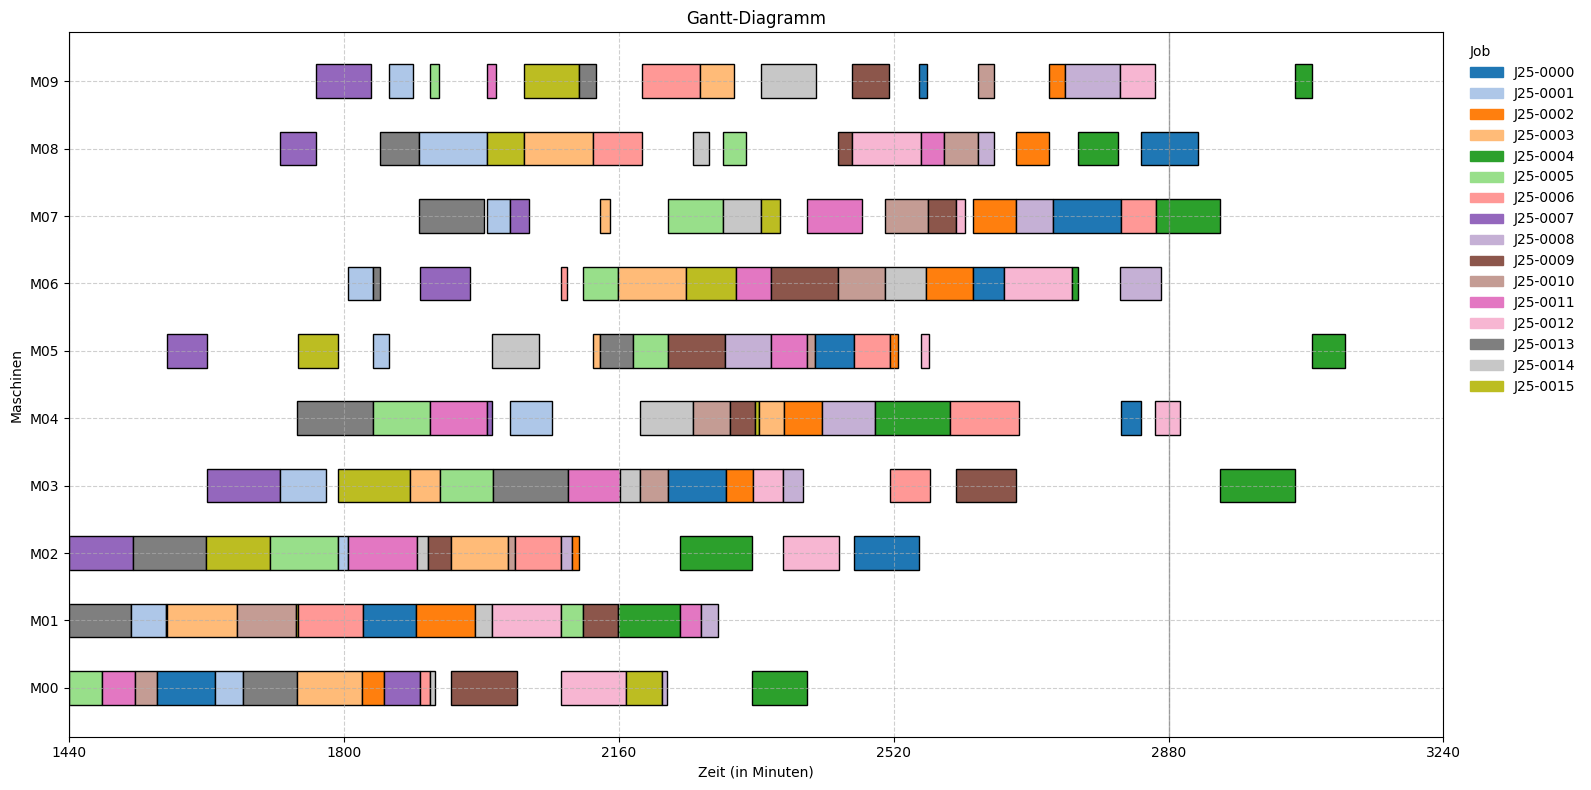

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [12]:
gantt.get_plot(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

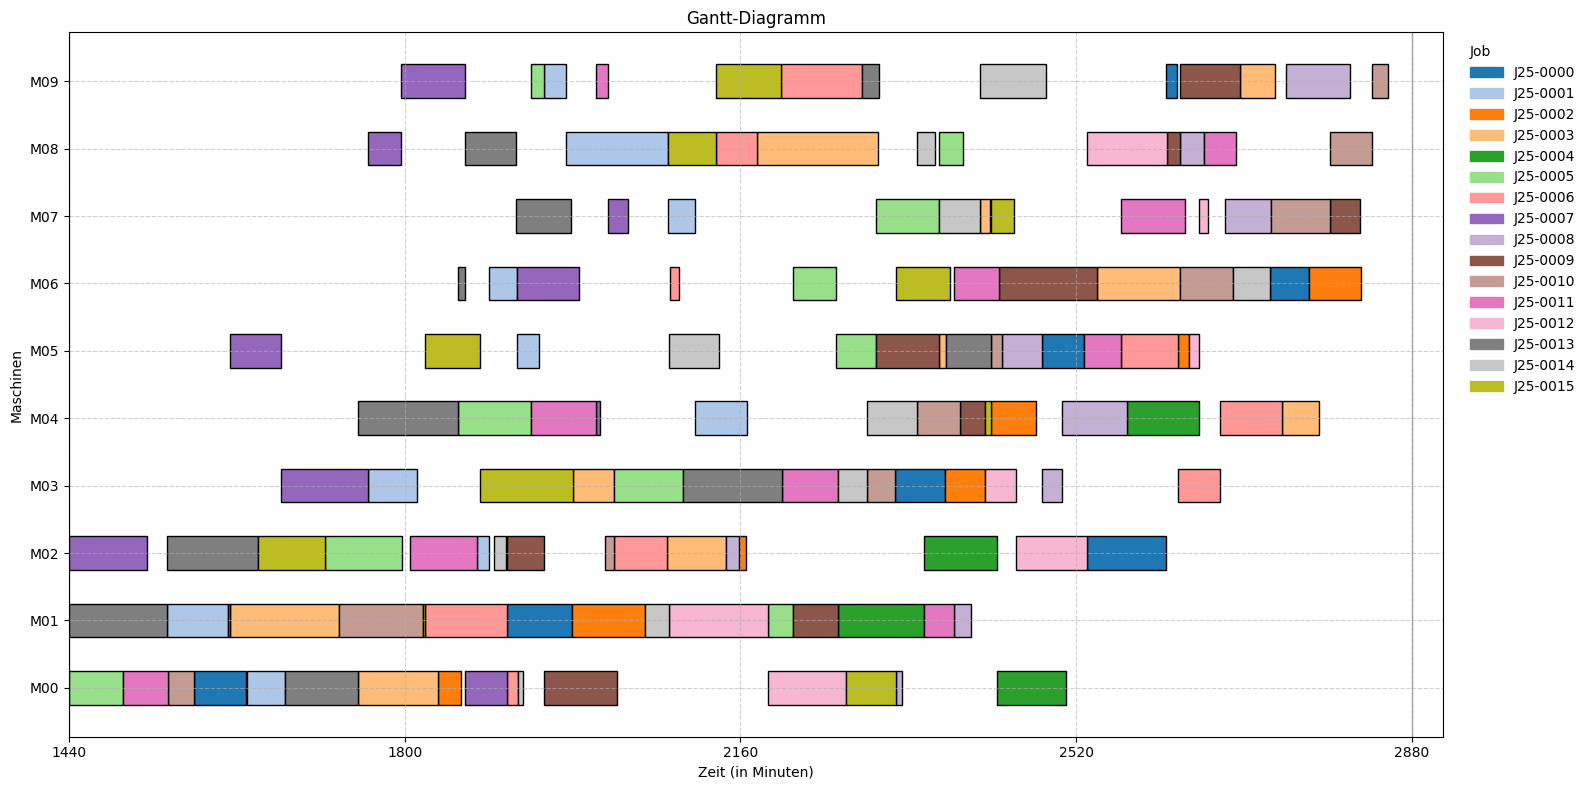

In [13]:
gantt.get_plot(df_execution, perspective="Machine")

In [14]:
df_active = simulation.get_active_operations_df()
df_active

,Routing_ID,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,8,J25-0000,7,M07,79,2824.0,89,82.0,2913.0,2906.0
1,7,J25-0009,9,M03,1004,2824.0,79,72.0,2903.0,2896.0
2,2,J25-0012,7,M06,1103,2826.0,89,113.0,2915.0,2939.0


In [15]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,8,M04,2818,26,2844
1,J25-0000,8,79,1440,3660,9,M08,2844,74,2918
2,J25-0002,0,198,1440,3744,7,M07,2624,56,2680
3,J25-0002,0,198,1440,3744,8,M08,2680,44,2724
4,J25-0002,0,198,1440,3744,9,M09,2724,21,2745
5,J25-0004,3,287,1440,4856,4,M06,2753,9,2762
6,J25-0004,3,287,1440,4856,5,M08,2762,52,2814
7,J25-0004,3,287,1440,4856,6,M07,2863,85,2948
8,J25-0004,3,287,1440,4856,7,M03,2948,98,3046
9,J25-0004,3,287,1440,4856,8,M09,3046,22,3068


#### b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline von Job $j$
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.

In [16]:
# Scheduling
df_schedule_b = cp_tard_schedule.solve_jssp_max(
    df_jssp_current, df_jobs_times_current, earliest_start_column = "Ready Time",
    msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule_b


Solver-Status        : OPTIMAL
Maximale Tardiness     : 0.0
Best Objective Bound   : 0.0
Laufzeit               : 0.05 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0000,8,79,1440,3660,9,M08,2844,74,2918
155,J25-0012,2,1103,1440,4385,9,M04,2862,33,2895
156,J25-0004,3,287,1440,4856,6,M07,2863,85,2948


## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [17]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [18]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
2,J25-0002,0,198,1440,2925.0,395,3744
4,J25-0004,3,287,1440,2697.0,655,4856
6,J25-0006,9,790,1440,2905.0,540,3539
8,J25-0008,4,988,1440,2986.0,393,3541
12,J25-0012,2,1103,1440,3011.0,568,4385
...,...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,4856.0,416,3881
33,J25-0033,2,2660,2880,5305.0,568,6738
34,J25-0034,8,2715,2880,5271.0,597,6387


In [19]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
8,J25-0000,8,8,M04,26
9,J25-0000,8,9,M08,74
27,J25-0002,0,7,M07,56
28,J25-0002,0,8,M08,44
29,J25-0002,0,9,M09,21
44,J25-0004,3,4,M06,9
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

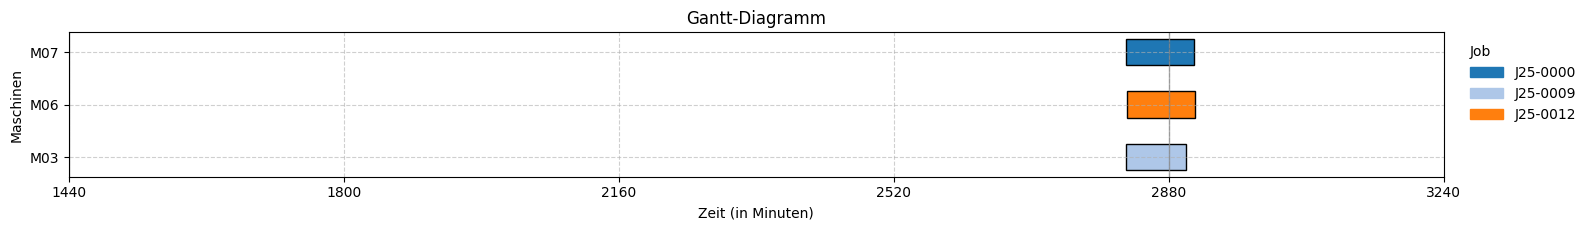

In [20]:
gantt.get_plot(df_active, perspective="Machine", duration_column="Planned Duration")

In [21]:
df_schedule_simple = cp_tard_reschedule.solve_jssp_sum_with_fixed_ops(
    df_jssp_current, df_jobs_times_current, df_active,
    reschedule_start = day_start, msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_simple


Solver-Status         : OPTIMAL
Summe Tardiness       : 0.0
Best Objective Bound  : 0.0
Laufzeit              : 0.08 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0031,1,2567,2880,4377,0,M00,2880,43,2923
1,J25-0032,6,2654,2880,3881,0,M01,2880,46,2926
2,J25-0035,5,2726,2880,4126,0,M02,2880,84,2964
3,J25-0000,8,79,1440,3660,8,M04,2906,26,2932
4,J25-0006,9,790,1440,3539,9,M07,2906,45,2951
5,J25-0023,8,2055,2880,4676,0,M00,2923,76,2999
...,...,...,...,...,...,...,...,...,...,...
229,J25-0034,8,2715,2880,6387,7,M07,4675,89,4764
230,J25-0030,0,2313,2880,6015,9,M09,4719,21,4740
231,J25-0033,2,2660,2880,6738,8,M09,4740,45,4785


#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

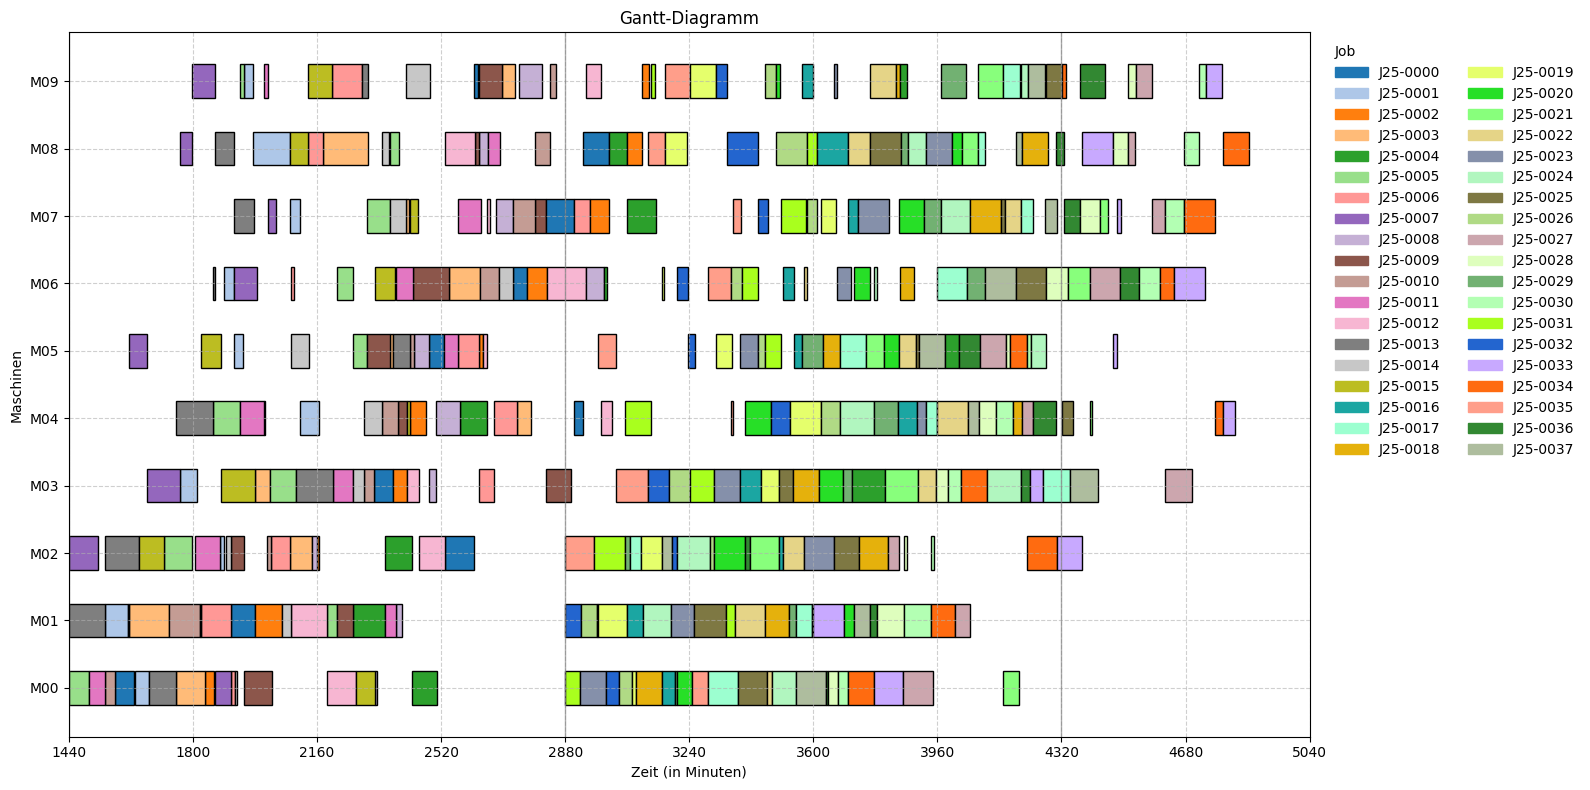

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [22]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

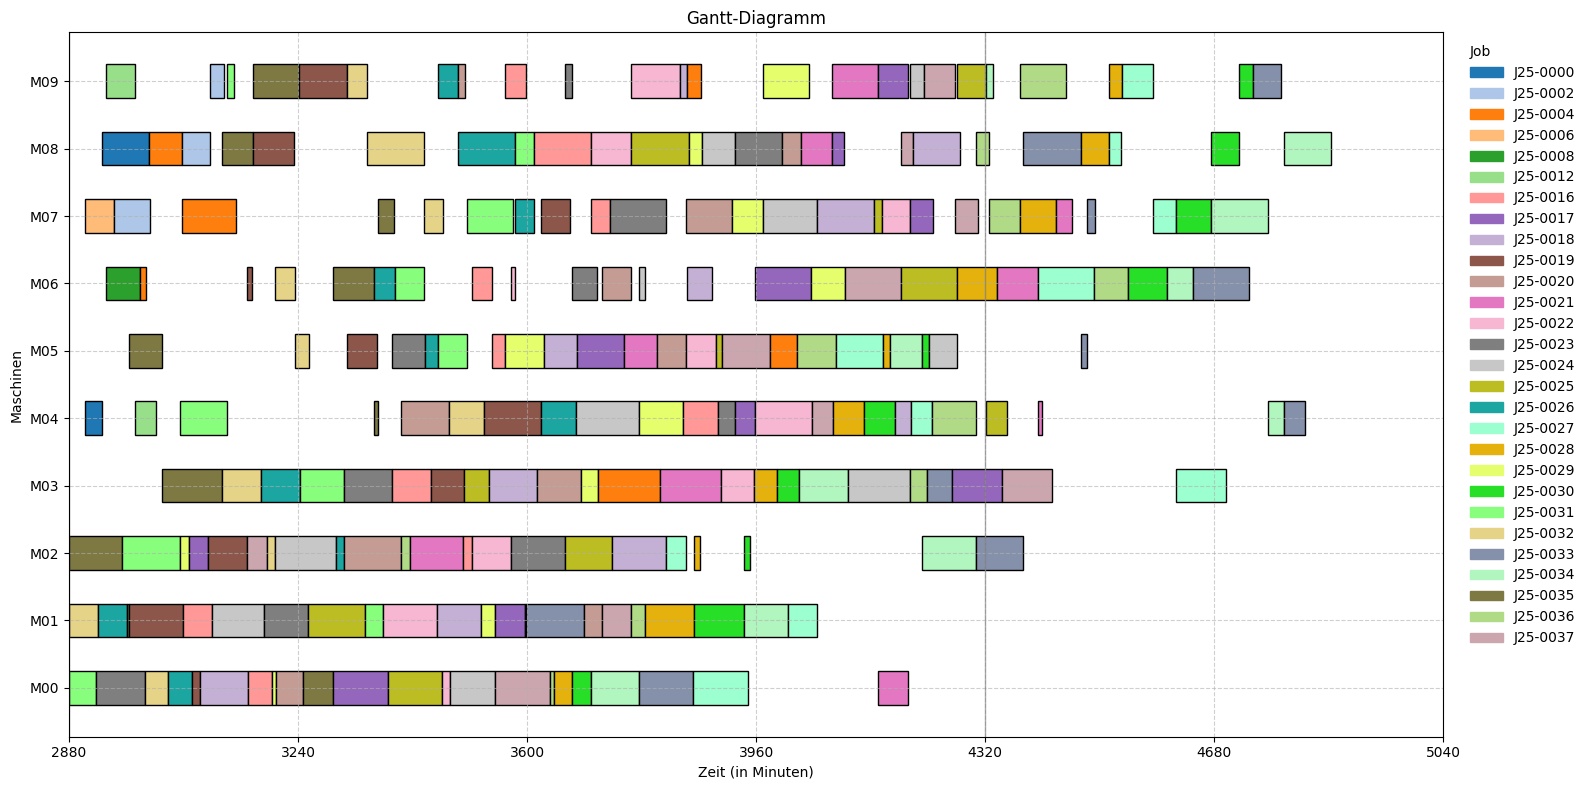

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_temp =  df_schedule_simple
gantt.get_plot(df_temp, perspective="Machine")
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

In [24]:
df_schedule_devpen = cp_tard_reschedule.solve_jssp_sum_with_devpen(
    df_jssp_current, df_jobs_times_current, df_active,
    df_original_plan = df_schedule,                     # prev. Plan
    r = 0.60,                                           # 60% Flowtime, 40% Abweichung
    reschedule_start = day_start,
    msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_devpen


Solver-Status         : OPTIMAL
Objective Value       : 107480.00
Best Objective Bound  : 105440.00
Laufzeit              : 0.31 Sekunden
Deviation terms       : 15


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0031,1,2567,2880,4377,0,M00,2880,43,2923
1,J25-0032,6,2654,2880,3881,0,M01,2880,46,2926
2,J25-0035,5,2726,2880,4126,0,M02,2880,84,2964
3,J25-0000,8,79,1440,3660,8,M04,2906,26,2932
4,J25-0006,9,790,1440,3539,9,M07,2906,45,2951
5,J25-0026,6,2192,2880,4415,0,M01,2926,46,2972
...,...,...,...,...,...,...,...,...,...,...
229,J25-0036,4,2734,2880,5231,8,M09,4831,72,4903
230,J25-0037,7,2801,2880,5173,6,M08,4882,19,4901
231,J25-0036,4,2734,2880,5231,9,M06,4903,53,4956


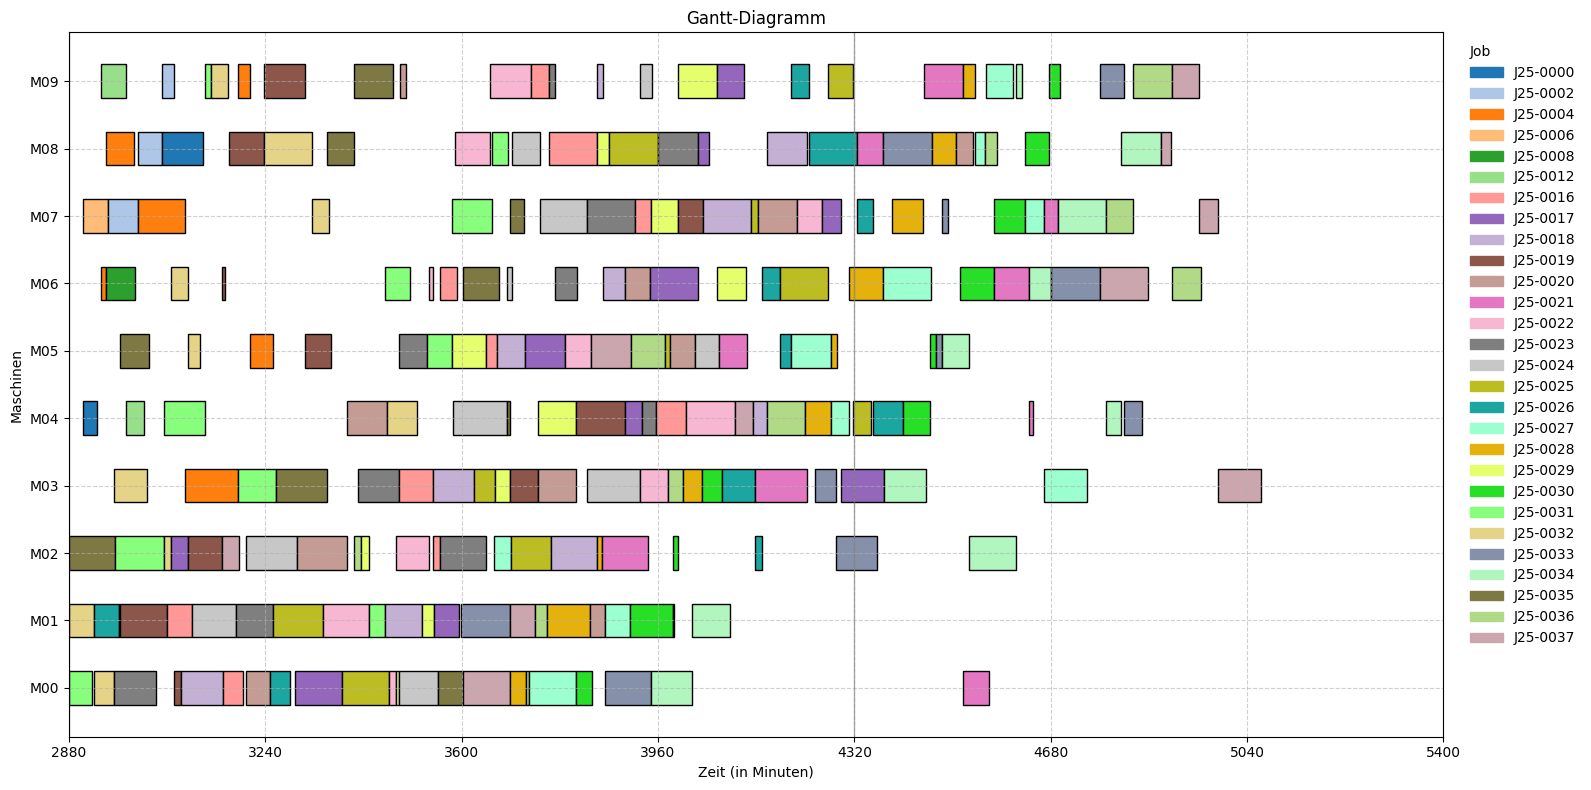

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [25]:
df_temp =  df_schedule_devpen
gantt.get_plot(df_temp, perspective="Machine")
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

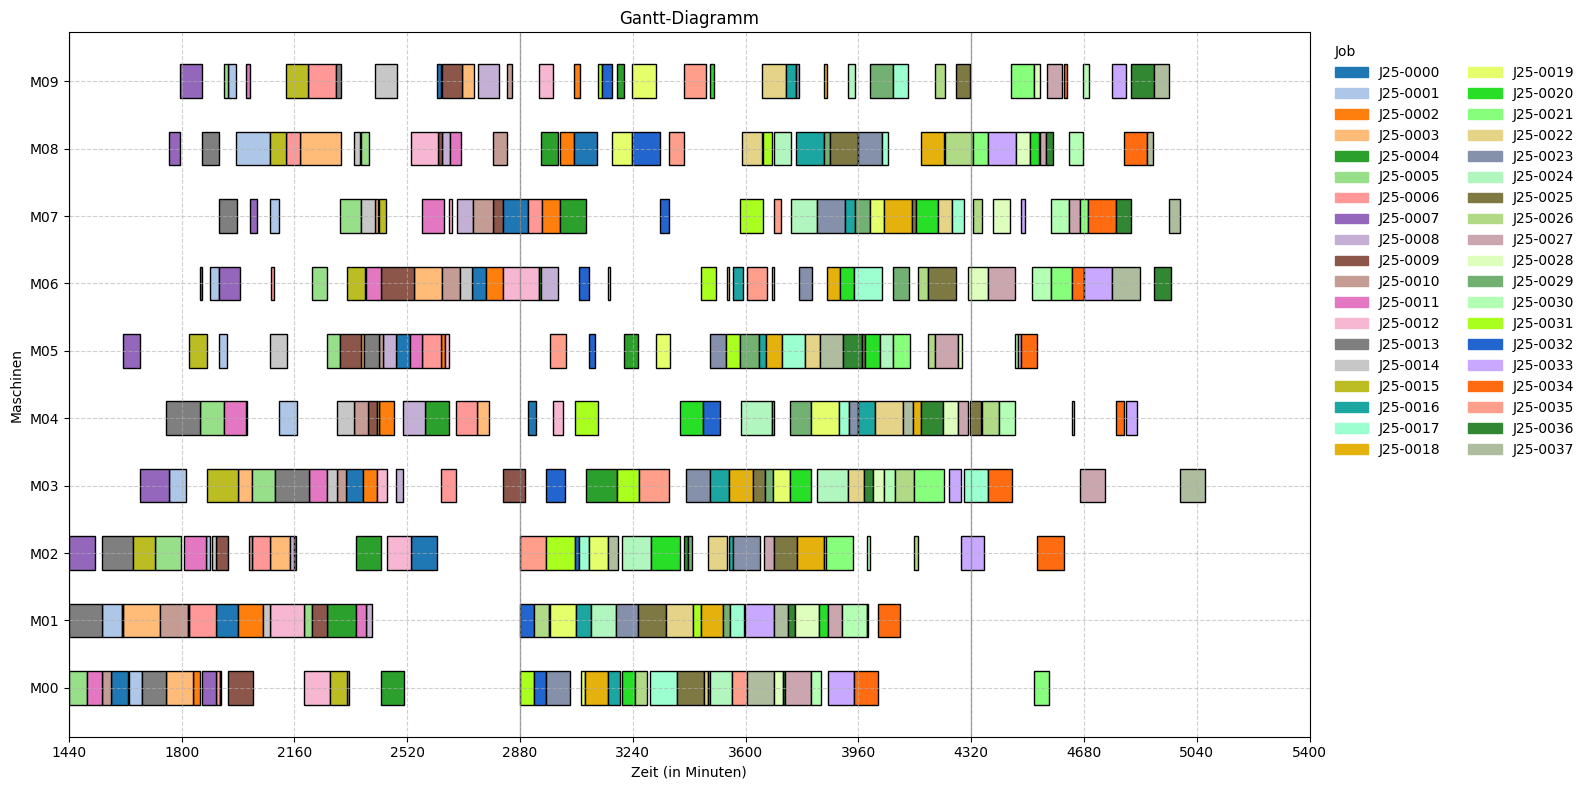

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [26]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [27]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

Remaining time: 26.0
Start time: 2880
End time: 2906.0
[Day 2 00:00:00] Job J25-0000, Operation 7 resumed on M07 (with 26 minutes left)
Remaining time: 16.0
Start time: 2880
End time: 2896.0
[Day 2 00:00:00] Job J25-0009, Operation 9 resumed on M03 (with 16 minutes left)
Remaining time: 59.0
Start time: 2880
End time: 2939.0
[Day 2 00:00:00] Job J25-0012, Operation 7 resumed on M06 (with 59 minutes left)
[Day 2 00:00:00] Job J25-0031 started on M00
[Day 2 00:00:00] Job J25-0032 started on M01
[Day 2 00:00:00] Job J25-0035 started on M02
[Day 2 00:16:00] Job J25-0009 finished on M03 (after 16 minutes)
[Day 2 00:26:00] Job J25-0000 finished on M07 (after 26 minutes)
[Day 2 00:26:00] Job J25-0000 started on M04
[Day 2 00:26:00] Job J25-0006 started on M07
[Day 2 00:40:00] Job J25-0031 finished on M00 (after 40 minutes)
[Day 2 00:43:00] Job J25-0032 finished on M01 (after 43 minutes)
[Day 2 00:46:00] Job J25-0026 started on M01
[Day 2 00:46:00] Job J25-0032 started on M00
[Day 2 00:52:00] 

In [28]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Routing_ID,Arrival,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,7,M07,2824.0,82.0,2906.0
1,J25-0000,8,79,8,M04,2906.0,26.0,2932.0
2,J25-0000,8,79,9,M08,3051.0,66.0,3117.0
3,J25-0002,0,198,7,M07,2951.0,43.0,2994.0
4,J25-0002,0,198,8,M08,3012.0,37.0,3049.0
5,J25-0002,0,198,9,M09,3051.0,19.0,3070.0
...,...,...,...,...,...,...,...,...
180,J25-0036,4,2734,5,M04,4170.0,66.0,4236.0
181,J25-0037,7,2801,0,M02,3175.0,29.0,3204.0
182,J25-0037,7,2801,1,M00,3620.0,80.0,3700.0


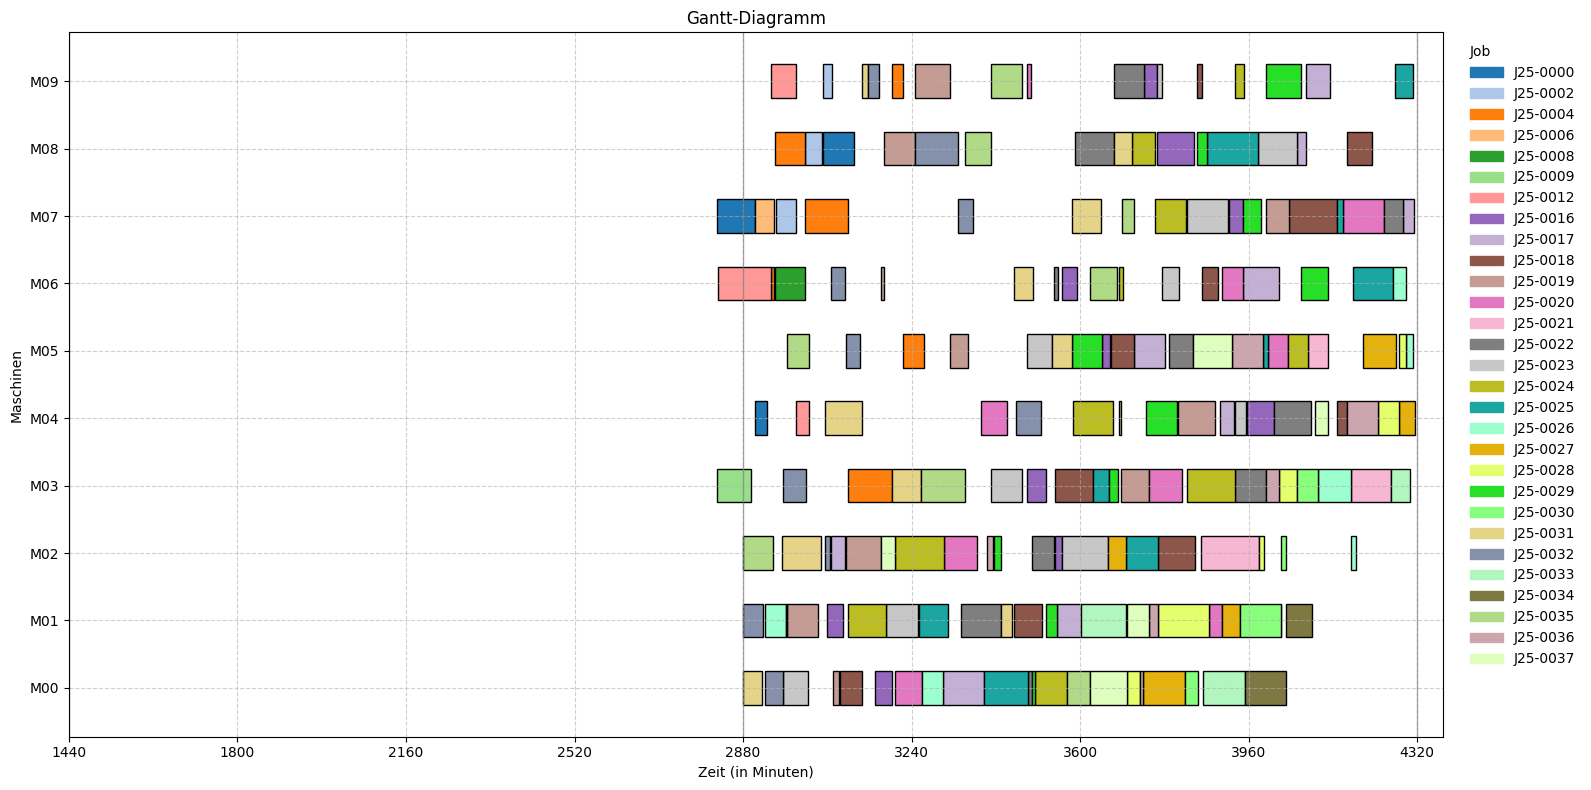

In [29]:
gantt.get_plot(df_execution2, perspective="Machine")


In [30]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Routing_ID,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,7,J25-0017,9,M03,1864,4312.0,79,87.0,4391.0,4399.0
1,2,J25-0025,9,M04,2126,4317.0,33,35.0,4350.0,4352.0
2,6,J25-0026,6,M09,2192,4311.0,32,34.0,4343.0,4345.0
3,0,J25-0028,6,M06,2282,4311.0,62,70.0,4373.0,4381.0
4,2,J25-0033,3,M02,2660,4305.0,74,78.0,4379.0,4383.0


In [31]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,0,M00,1555,76,1631
1,J25-0000,8,79,1440,3660,1,M01,1825,69,1894
2,J25-0000,8,79,1440,3660,2,M03,2224,76,2300
3,J25-0000,8,79,1440,3660,3,M05,2417,51,2468
4,J25-0000,8,79,1440,3660,4,M02,2468,85,2553
5,J25-0000,8,79,1440,3660,5,M09,2553,11,2564
...,...,...,...,...,...,...,...,...,...,...
136,J25-0015,5,1436,1440,2981,4,M08,1988,48,2036
137,J25-0015,5,1436,1440,2981,5,M09,2036,72,2108
138,J25-0015,5,1436,1440,2981,6,M00,2170,47,2217


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

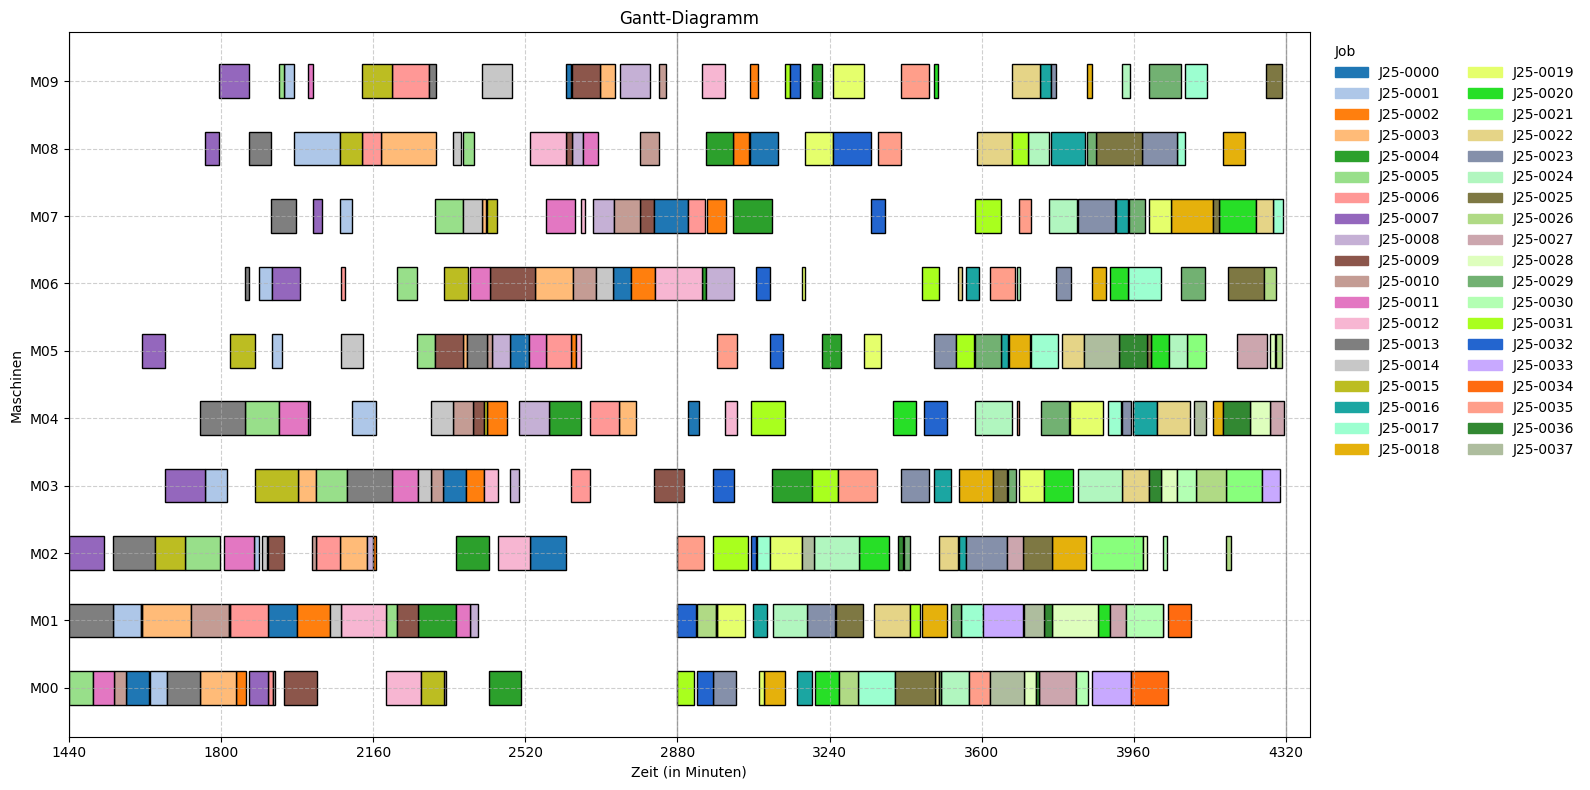

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [32]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)